#### Correlation between the 2021 Super Bowl and a possible rise in cases of COVID-19

In [105]:
import pandas as pd
from datetime import date, timedelta
import piecewise_regression
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc as pm
import arviz as az
import numpy as np
import sdt.changepoint as c
import math

In [106]:
file_path = "./covid_confirmed_usafacts.csv"
# Read the CSV file using pandas
dataframe = pd.read_csv(file_path)
#get rid of all the rows with county name = Statewide Unallocated
dataframe = dataframe[dataframe['County Name'] != 'Statewide Unallocated']
#get rid of all the rows with county name = Out of Country
dataframe = dataframe[dataframe['County Name'] != 'Out of Country']

In [107]:
#CREATION OF THE DATAFRAME
# Specify the file path or URL of the CSV file

#restrict the date range to 2021-01-23 to 2021-02-23 but keep state, countyFIPS and StateFIPS
#aggregate by state
grouped = dataframe.groupby('State').sum()
#rename the grouped column as State
grouped = grouped.rename_axis('Date').reset_index()
partGrouped = grouped[["Date"]]
start_date = date(2021, 1, 24) #moving average starts having values on the 24th of January
super_bowl_date = date(2021, 2, 7)
sbplus7_date = date(2021, 2, 14)
sbplus14_date = date(2021, 2, 21)

difference = super_bowl_date - start_date


end_date = date(2021, 3, 7)   
final_diff = end_date - start_date
delta = end_date - start_date   # returns timedelta
listdays = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    listdays.append(day.strftime("%Y-%m-%d"))
#istdays.insert(0, 'State')
otherGrouped = grouped[listdays]
#join the two dataframes
grouped = pd.concat([partGrouped, otherGrouped], axis=1)
grouped = grouped.T
grouped.columns = grouped.iloc[0]
grouped = grouped.iloc[1: , :]
#grouped.rename(columns = {'State':'Date'}, inplace = True )
grouped.head()

dataframe_list = []
print(grouped.columns)
for col in grouped.columns[1:]:
    dataframe_list.append(grouped[[col]])

for d in dataframe_list:
    #add colun with moving average for each day
    d['MAV'] = d.rolling(window=7).mean()
    #add column with the difference between the moving average of the current day and the moving average of the previous day
    d['Diff'] = d['MAV'].diff()
    d.dropna(inplace=True)
    d.index = pd.to_datetime(d.index)

print(dataframe_list[33])


Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='Date')
Date             NY           MAV          Diff
2021-01-31  1410656  1.374598e+06  11952.714286
2021-02-01  1419164  1.386051e+06  11453.428571
2021-02-02  1427379  1.397098e+06  11046.428571
2021-02-03  1433304  1.407415e+06  10317.428571
2021-02-04  1440718  1.416878e+06   9462.571429
2021-02-05  1449495  1.425797e+06   8919.428571
2021-02-06  1449495  1.432887e+06   7090.285714
2021-02-07  1470772  1.441475e+06   8588.000000
2021-02-08  1479220  1.450055e+06   8579.428571
2021-02-09  1487086  1.458584e+06   8529.571429
2021-02-10  1494187  1.467282e+06   8697.571429
2021-02-11  1504286  1.476363e+06   9081.142857

C:\Users\Simone\AppData\Local\Temp\ipykernel_14080\595192966.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['MAV'] = d.rolling(window=7).mean()
C:\Users\Simone\AppData\Local\Temp\ipykernel_14080\595192966.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Diff'] = d['MAV'].diff()
C:\Users\Simone\AppData\Local\Temp\ipykernel_14080\595192966.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

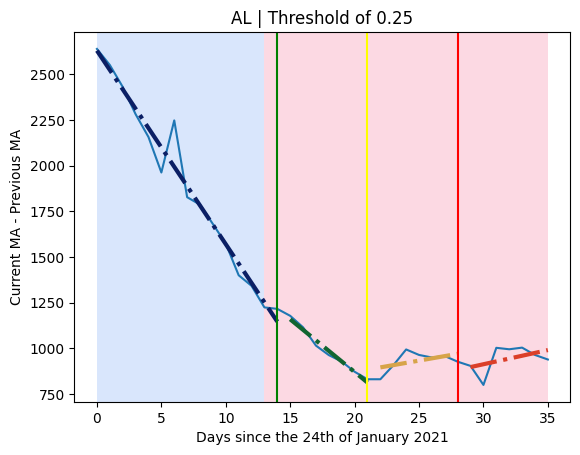

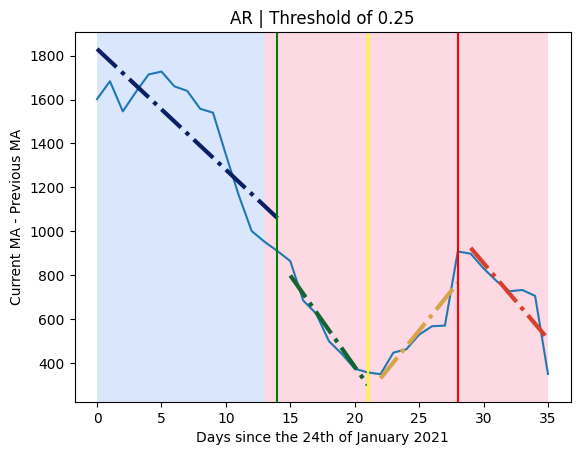

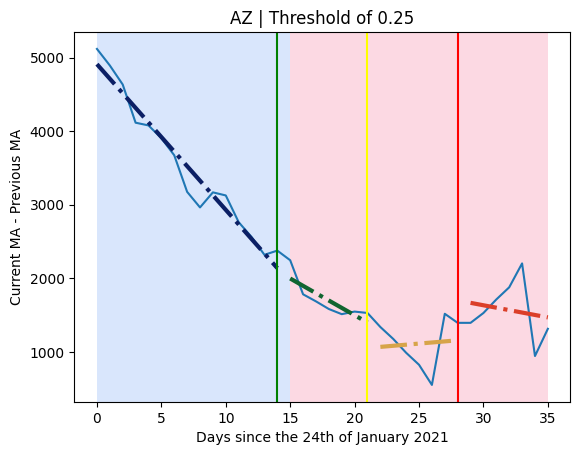

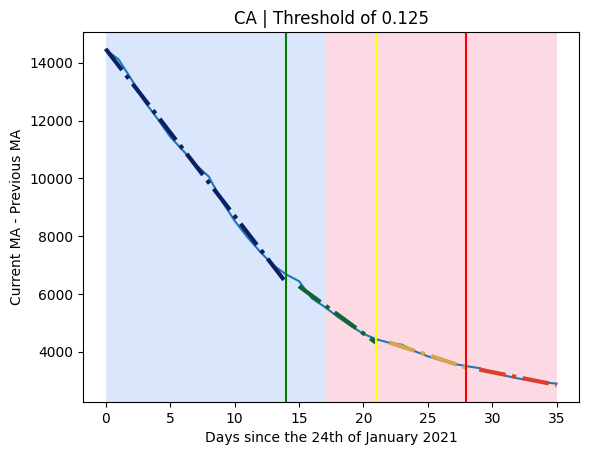

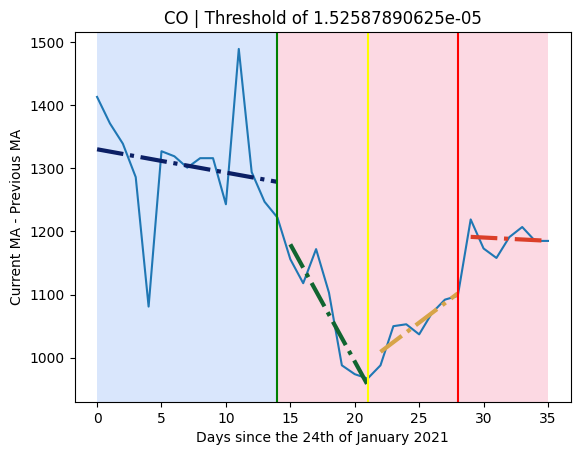

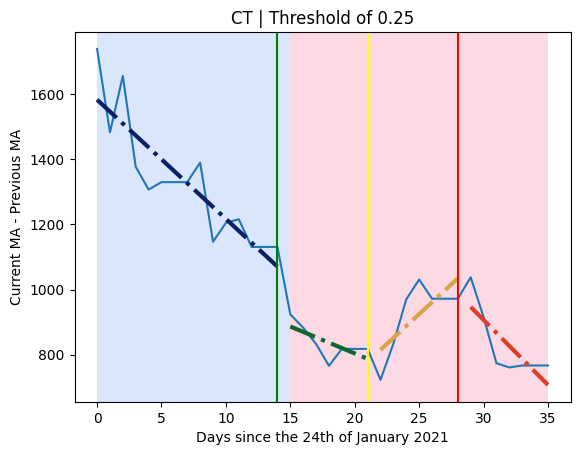

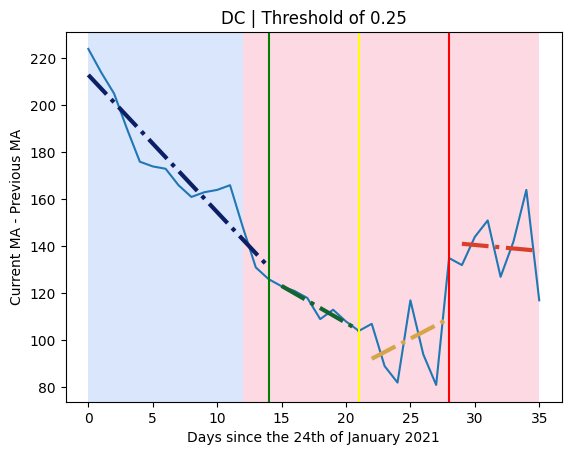

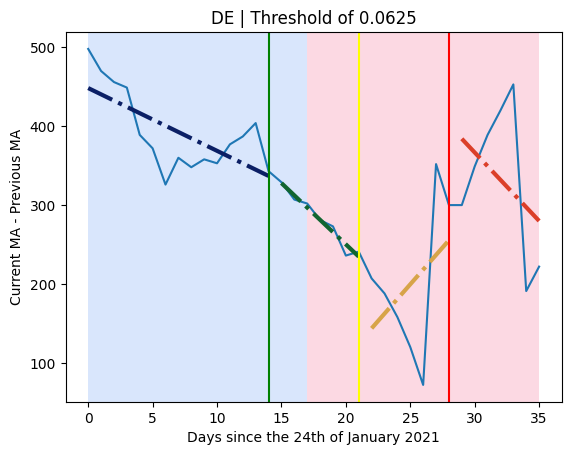

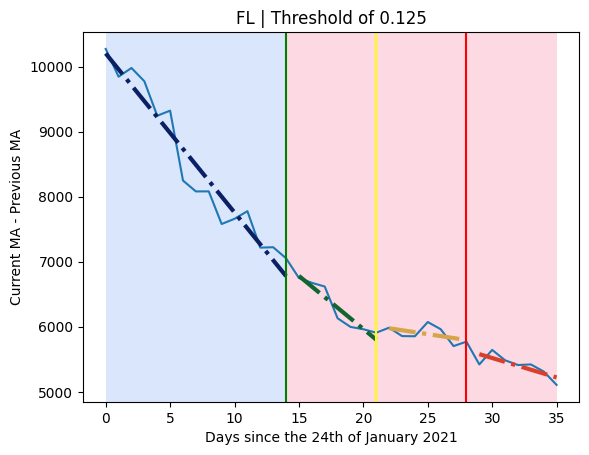

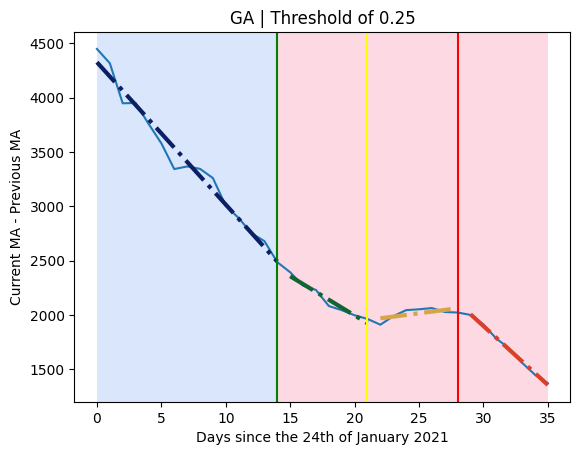

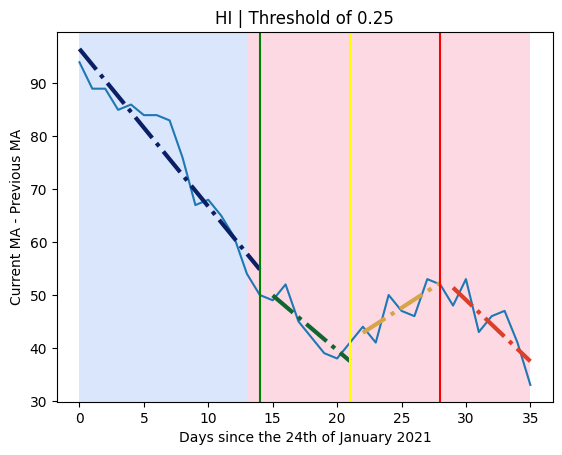

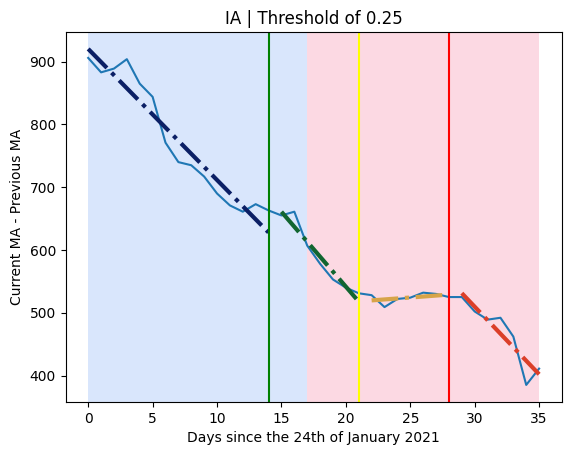

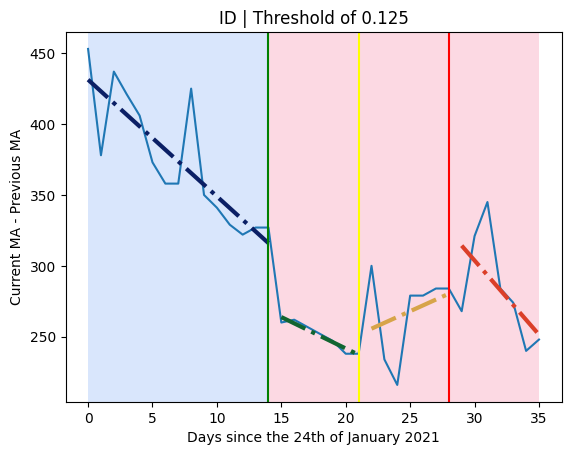

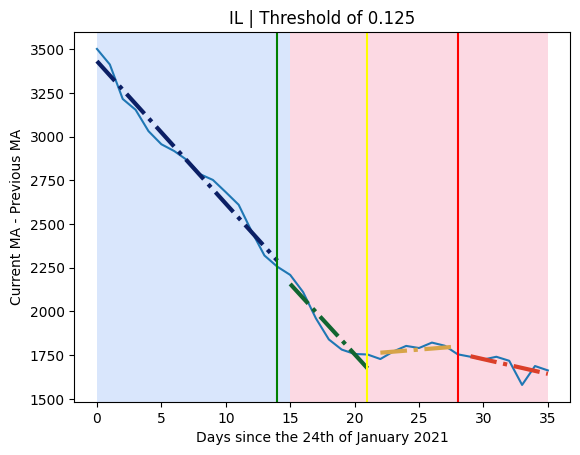

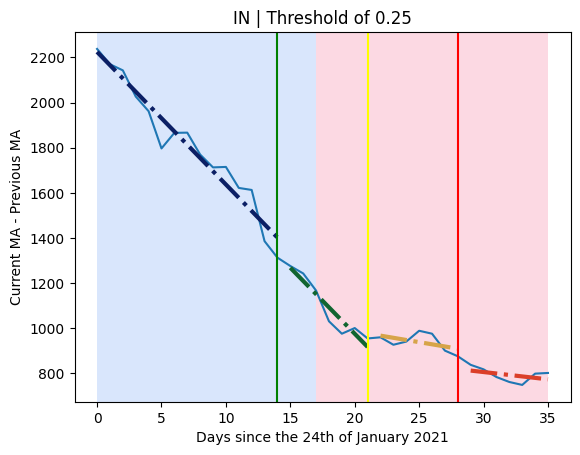

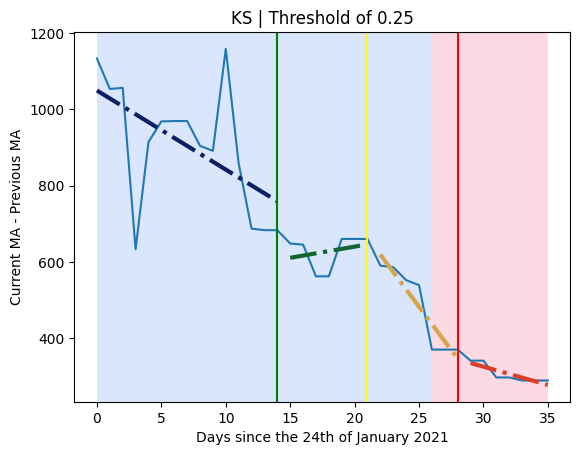

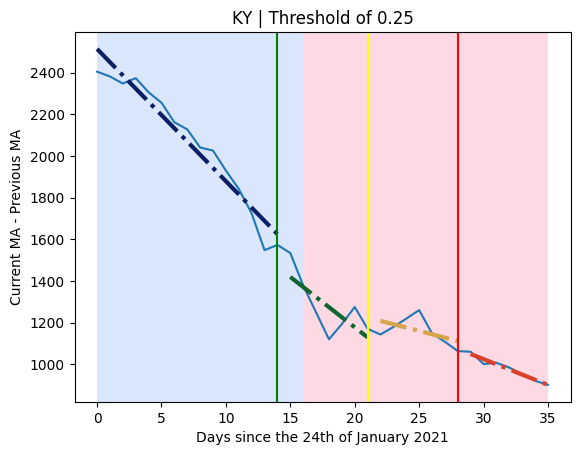

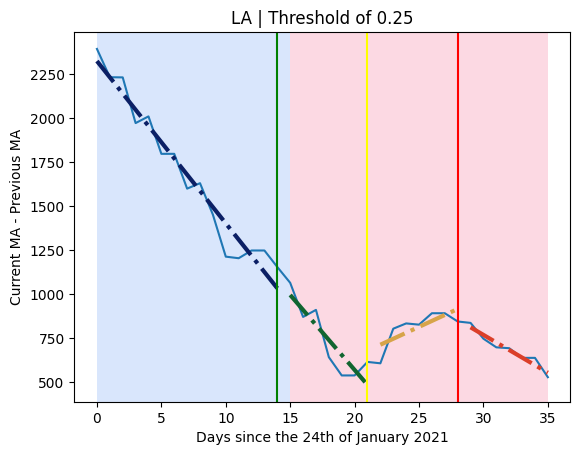

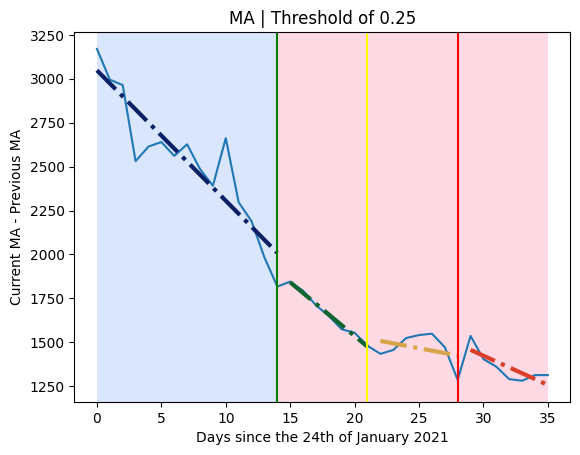

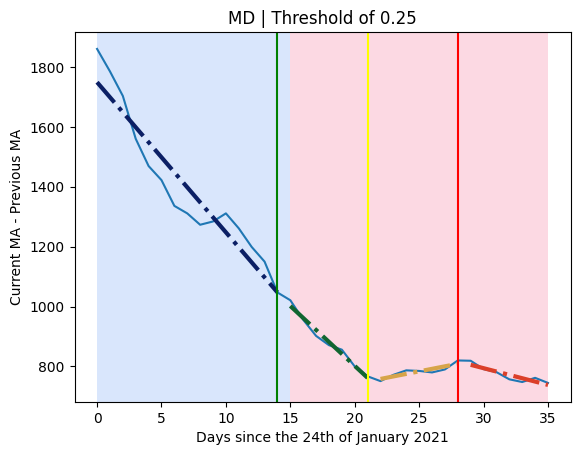

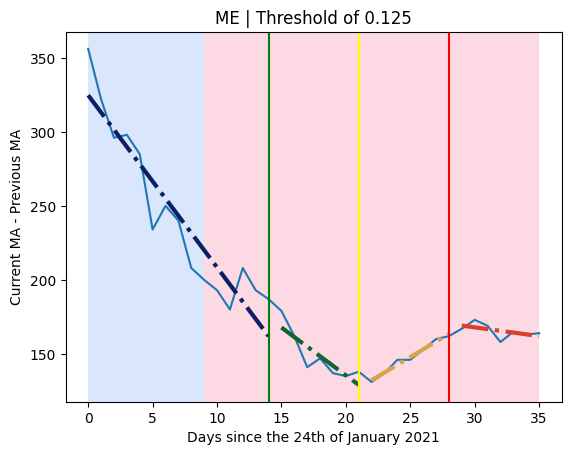

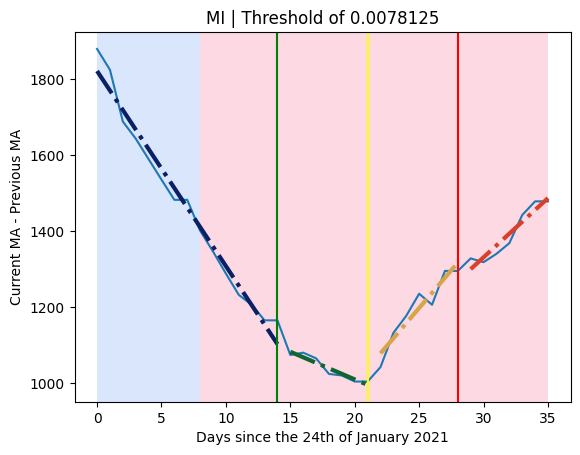

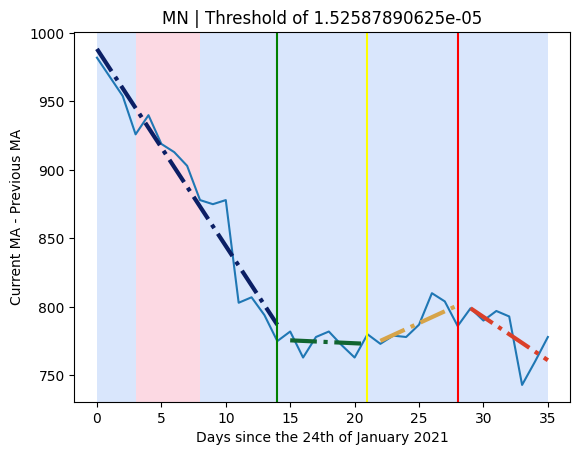

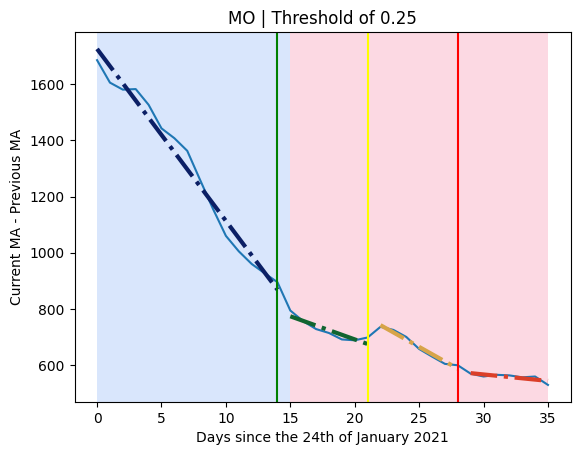

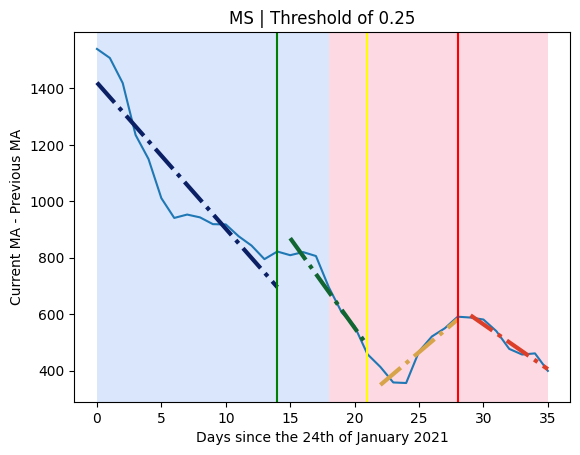

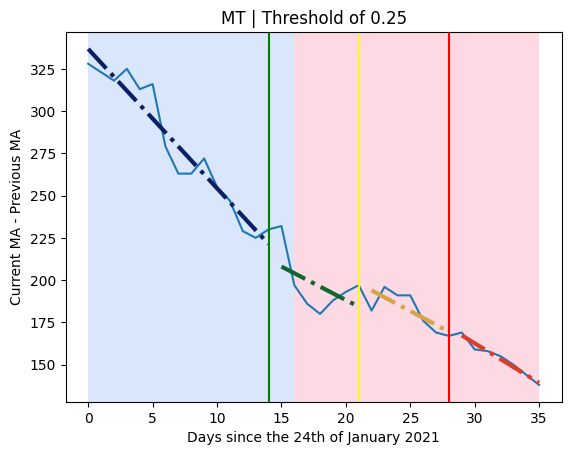

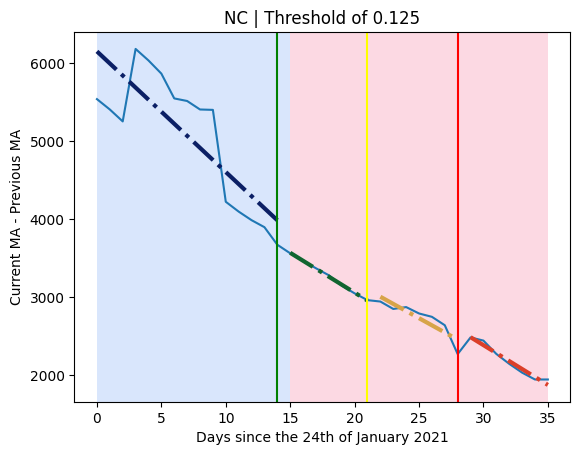

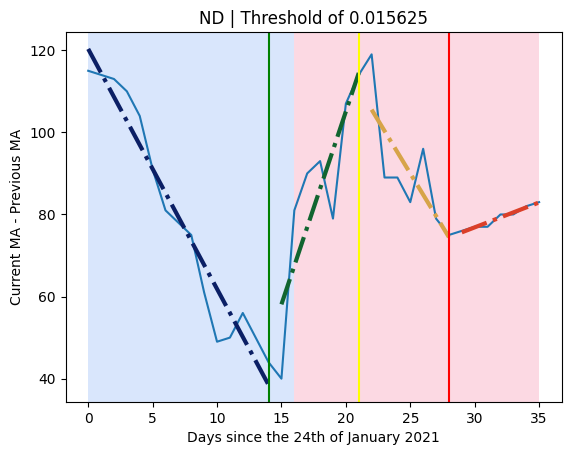

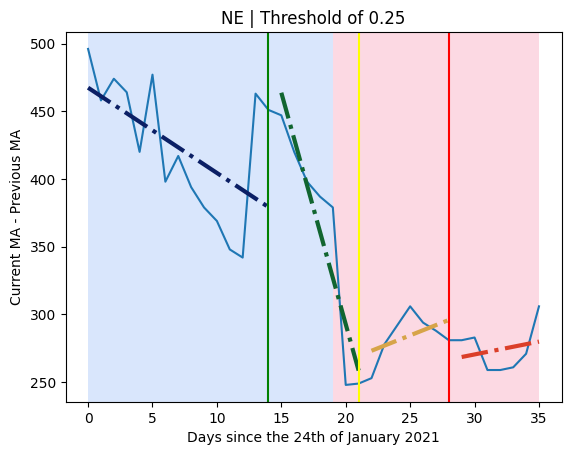

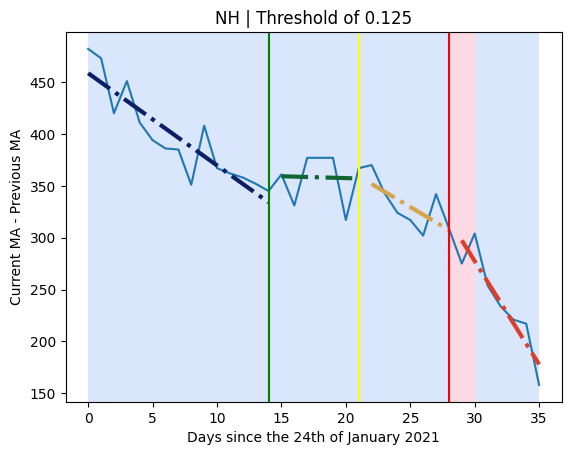

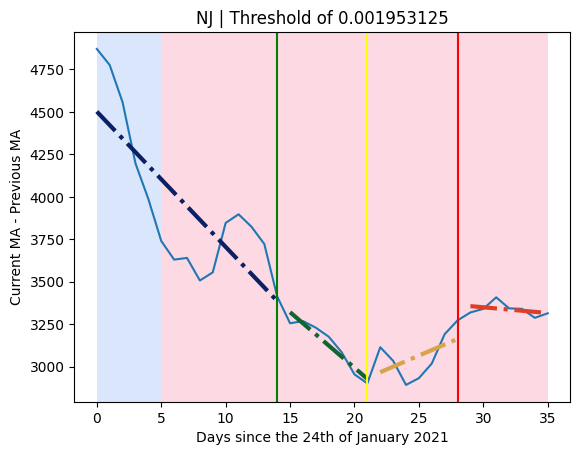

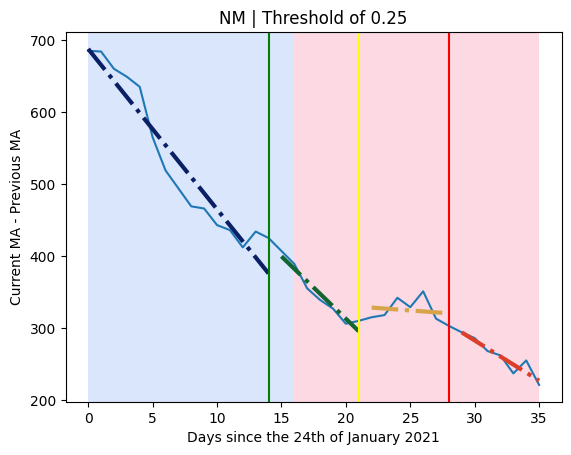

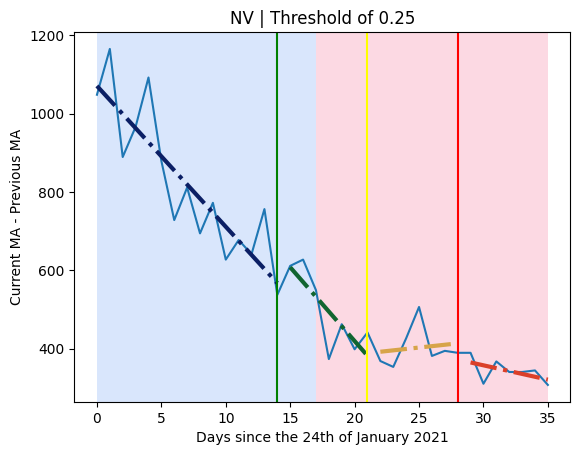

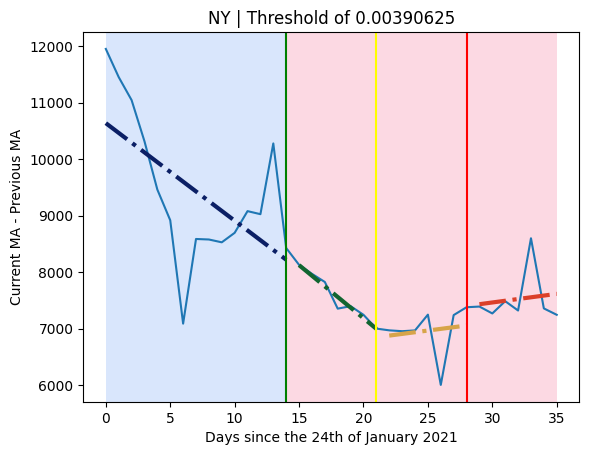

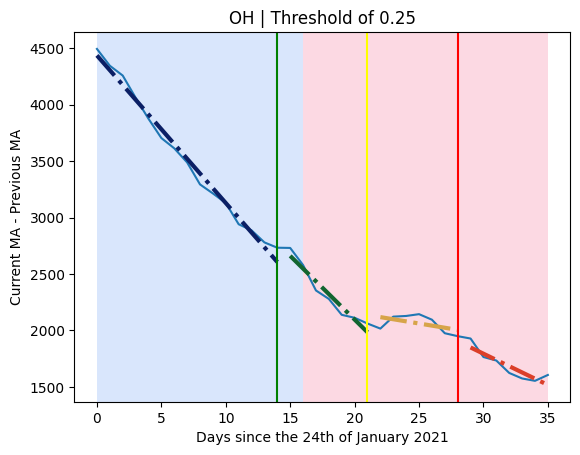

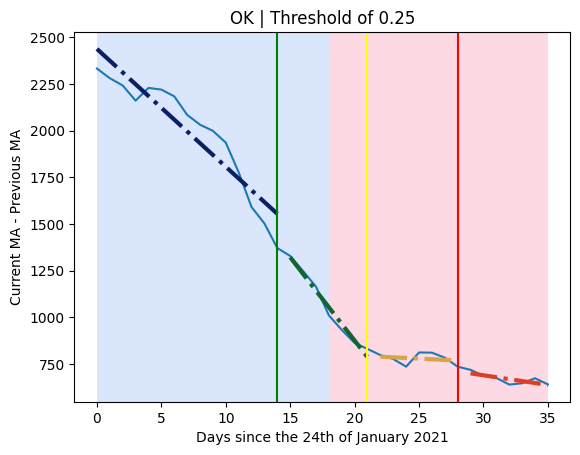

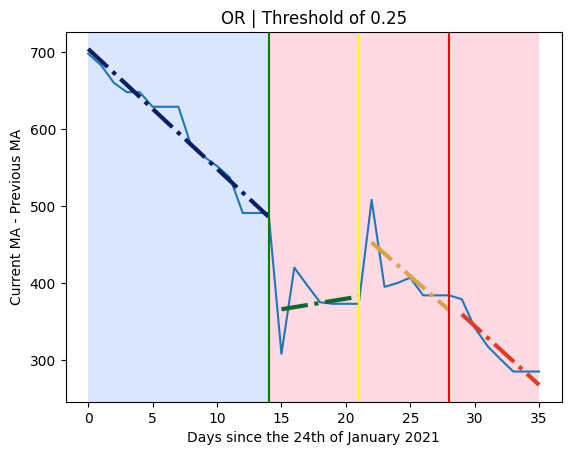

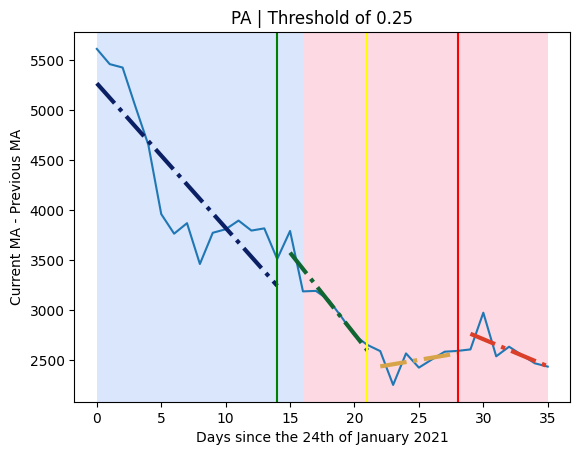

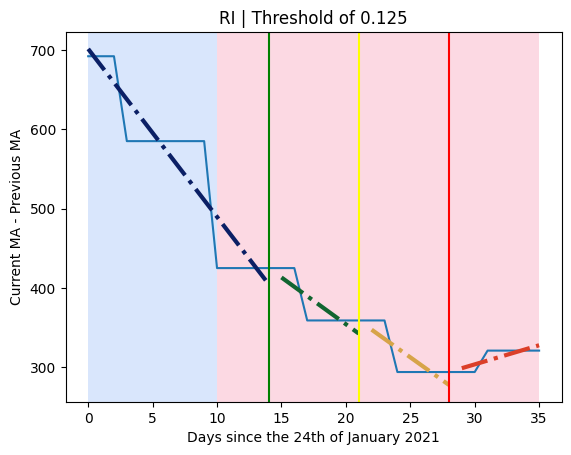

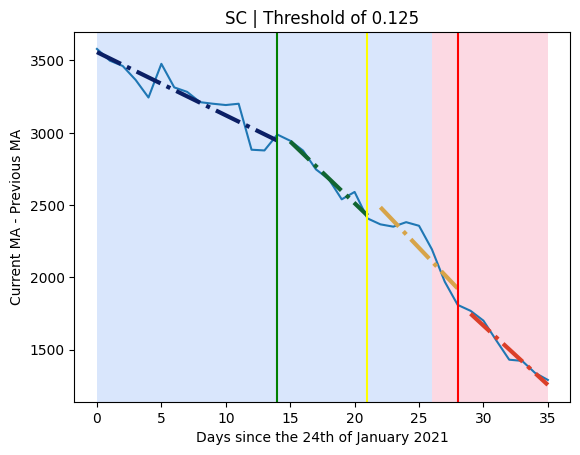

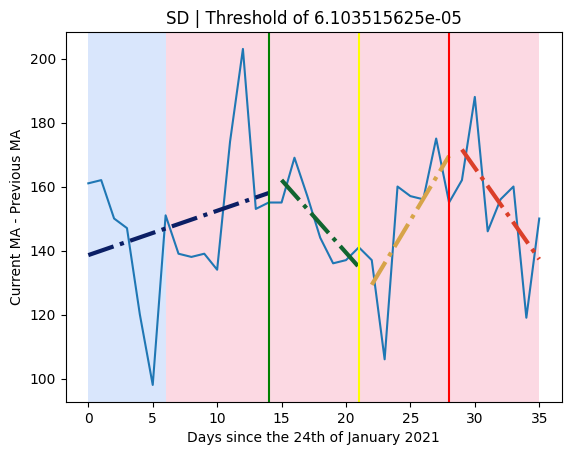

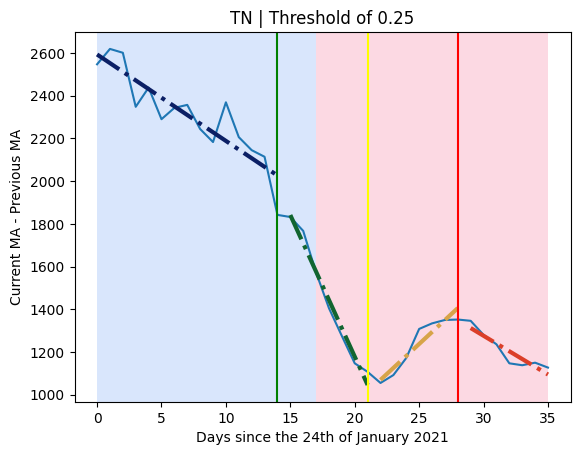

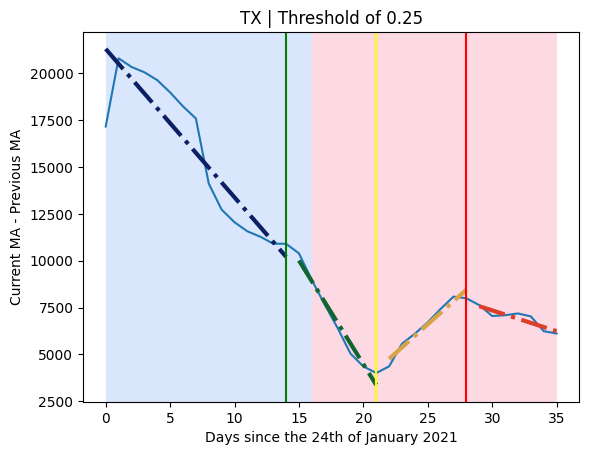

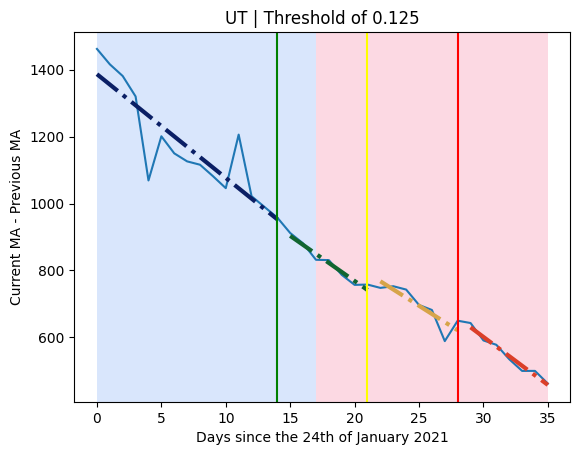

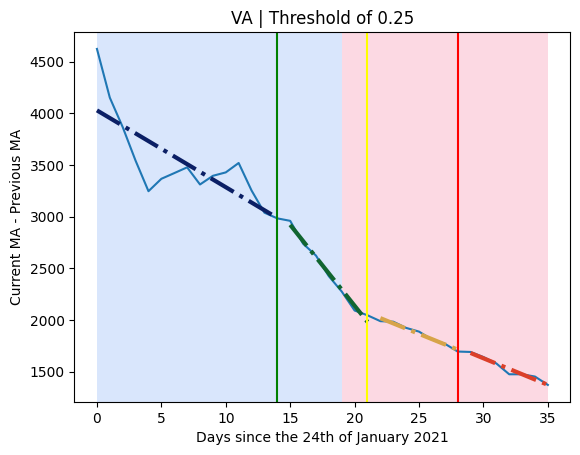

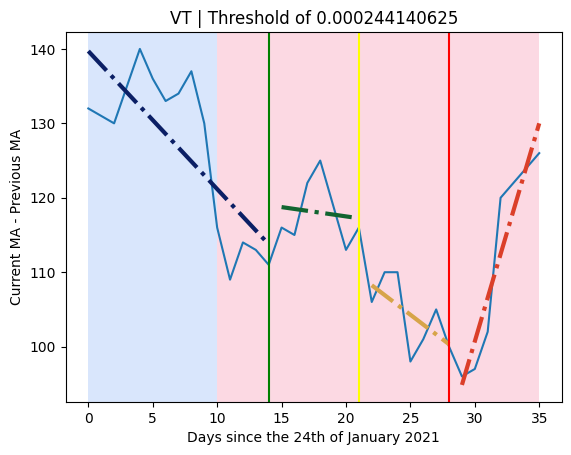

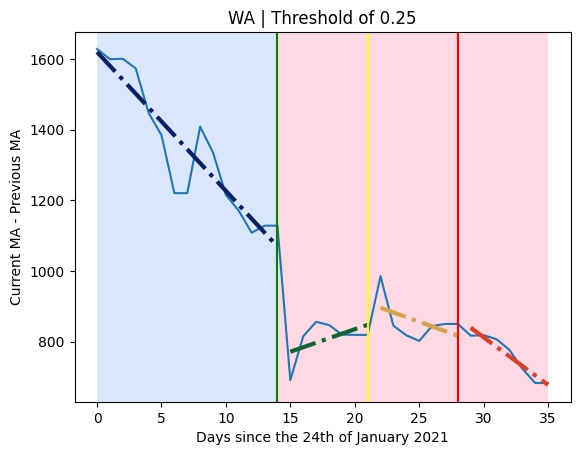

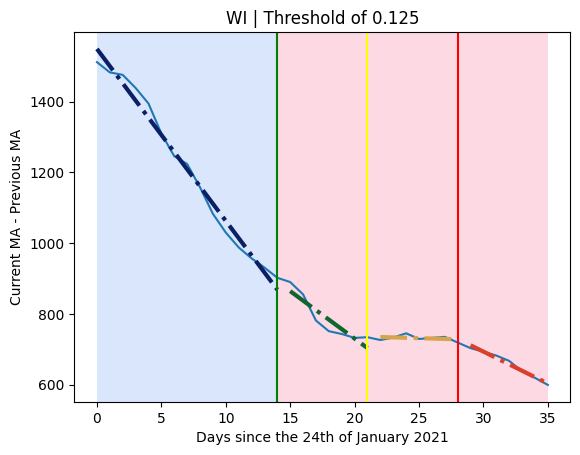

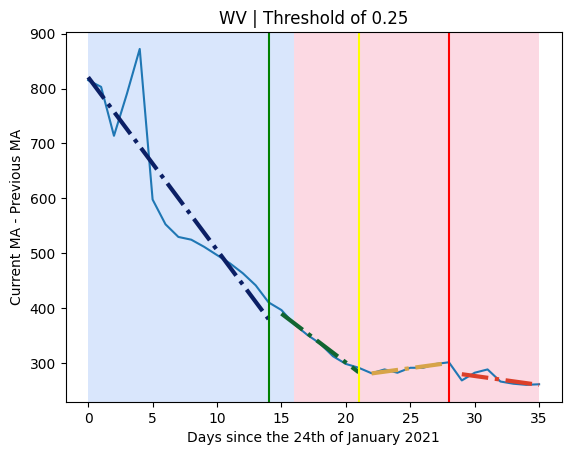

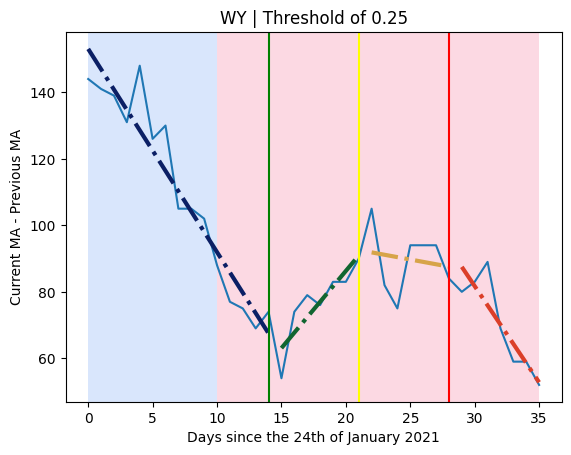

Media: 15.038461538461538
Count: 52.0
Difference: 14


In [114]:
def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

BayesOffline = c.BayesOffline()
media_changepoint = 0.0
count_changepoint = 0.0

tabella = pd.DataFrame(columns=['State','FirstSlope','SecondSlope','ThirdSlope','FourthSlope'])
for df in dataframe_list:
    df = df.astype(int)
    values = df[df.columns.values[2]].values

    df2 = df[df.columns.values[2]]
    values_before = df2.iloc[:difference.days+1].values
    values_oneWeek = df2.iloc[difference.days+1:difference.days+8].values
    values_twoWeek = df2.iloc[difference.days+8:difference.days+15].values
    values_after = df2.iloc[difference.days+15:].values

    # Out is a list of possible changepoint "indices"
    prob = 0.5
    out = []
    while len(out) == 0:
        prob = prob * 0.5
        out = BayesOffline.find_changepoints(values, prob_threshold=prob)
    for i in out:
        media_changepoint += i
        count_changepoint += 1
    # Plot the data.
    c.plot_changepoints(values, out)
    z1 = np.polyfit(range(0,len(values_before)), values_before, 1)
    #print ("{0}x + {1}".format(*z1))
    p1 = np.poly1d(z1)
    z2 = np.polyfit(range(len(values_before),len(values_before)+len(values_oneWeek)), values_oneWeek, 1)
    p2 = np.poly1d(z2)
    z3 = np.polyfit(range(len(values_before)+len(values_oneWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)), values_twoWeek, 1)
    p3 = np.poly1d(z3)
    z4 = np.polyfit(range(len(values_before)+len(values_oneWeek)+len(values_twoWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after)), values_after, 1)
    p4 = np.poly1d(z4)
    
    entry = pd.DataFrame.from_dict({"State": [df.columns.values[0]],'FirstSlope': [round_half_up(z1[0])],'SecondSlope': [round_half_up(z2[0])],'ThirdSlope': [round_half_up(z3[0])],'FourthSlope': [round_half_up(z4[0])]
})
    tabella = pd.concat([tabella, entry], ignore_index=True)

    array1 = np.arange(0,len(values_before))
    array2 = np.arange(len(values_before),len(values_before)+len(values_oneWeek))
    array3 = np.arange(len(values_before)+len(values_oneWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek))
    array4 = np.arange(len(values_before)+len(values_oneWeek)+len(values_twoWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after))

    '''vfunc = np.vectorize(lambda t: t - 1)
    #array1 = vfunc(array1)
    array2 = vfunc(array2)
    array3 = vfunc(array3)
    array4 = vfunc(array4)'''


    plt.plot(array1, p1(range(0,len(values_before))), color="#0B1F65", linewidth=3, linestyle="dashdot")
    plt.plot(array2, p2(range(len(values_before),len(values_before)+len(values_oneWeek))), color="#116530", linewidth=3, linestyle="dashdot")
    #plt.plot(hole2,)
    plt.plot(array3, p3(range(len(values_before)+len(values_oneWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek))), color="#D7A449", linewidth=3, linestyle="dashdot")
    plt.plot(array4, p4(range(len(values_before)+len(values_oneWeek)+len(values_twoWeek),len(values_before)+len(values_oneWeek)+len(values_twoWeek)+len(values_after))), color="#DB3F29", linewidth=3, linestyle="dashdot")

    

    #plt.plot(values)
    plt.title(df.columns.values[0] + " | Threshold of " + str(prob))
    plt.axvline(x = difference.days, color = 'green', label = 'Super Bowl')
    plt.axvline(x = difference.days+7, color = 'yellow', label = 'Super Bowl')
    plt.axvline(x = difference.days+14, color = 'red', label = 'Super Bowl')
    plt.xlabel("Days since the 24th of January 2021")
    plt.ylabel("Current MA - Previous MA")
    plt.show()
print("Media: " + str(media_changepoint/count_changepoint))
print("Count: " + str(count_changepoint))
print("Difference: " + str(difference.days))

In [109]:
#
tabella.set_index(tabella['State'])
#tabella.drop(columns=['State'], inplace=True)
tabella = tabella.astype({tabella.columns.values[1]: 'string', tabella.columns.values[2]: 'int', tabella.columns.values[3]: 'int', tabella.columns.values[4]: 'int'})
print(tabella.head())
tabella.to_csv("./tabella.csv", index=False)

  State FirstSlope  SecondSlope  ThirdSlope  FourthSlope
0    AL     -106.0          -58          12           15
1    AR      -55.0          -83          72          -69
2    AZ     -198.0         -100          15          -33
3    CA     -578.0         -326        -145          -88
4    CO       -4.0          -37          15           -1
